# 🌠 Improving RAG by Optimizing Retrieval and Reranking Models

In this tutorial, we will show how to improve a RAG (Retrieval Augmented Generation) model by optimizing the retrieval and reranking models. For this purpose, we will use the `ArgillaTrainer` to fine-tune a `bi-encoder` and `cross-encoder` on two datasets with our own data.

The steps are as follows:

* 📝 Set up a QA pipeline with RAG using [Haystack](https://haystack.deepset.ai/overview/intro)
* 🗃️ Get the answers and contexts to create our own datasets
* 📩 Create the Argilla datasets and push them to the `Argilla UI`
* 💫 Fine-tune the `bi-encoder` and `cross-encoder`
* 🌌 Use our fine-tuned models to improve the original RAG model 


## Introduction

**LLMs** are a reality in our day-to-day lives. They are used in search engines, chatbots, and question-answering systems. However, they are not perfect. They often produce responses that are not relevant, accurate, or verifiable. To solve this problem, RAG (Retrieval-Agumented Generation) was introduced.

**RAG** is a framework that improves the quality of the responses using a pre-trained LLM and a retrieval model. This one is used to retrieve relevant information from a knowledge base (the web or your documents) which makes it more trustworthy for the user. In addition, RAG solves the common LLMs drawbacks as it can provide up-to-date and domain-specific data (even citing its sources) and it is more efficient and affordable (no need to retrain models from scratch).

In order to optimize the retrieval model, a **sentence similarity model** can be used. Why? To improve the accuracy and relevance of the retrieved information by finding the user's intent. This is done by transforming the text into embeddings (vectors representing the semantic information) and computing the similarity between those so that the meaning of the input text can be 'understood'. 

In this tutorial, we will fine-tune a sentence similarity model with a bi-encoder (faster but less accurate) and a cross-encoder (slower but more accurate). The **bi-encoder** creates sentence embeddings for the data and the query, and then compares them by computing the similarity between vectors. The **cross-encoder** does not use sentence embeddings but classifies the data pairs and outputs a value indicating the similarity between them. They can be used independently in a retriever or together as shown in the image below where the retrieval is the the initial step and involves searching through a vast dataset or collection to identify a subset of candidate documents, passages, or sentences that are potentially relevant to a given query or information requirement. Following this, the reranking phase takes place, where the candidates initially retrieved undergo reassessment and are reorganized based on their actual relevance to the query.

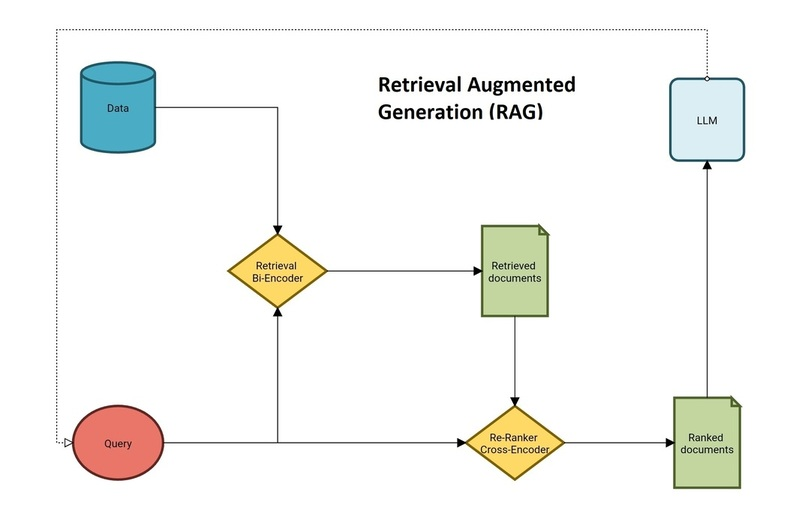

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:


**Deploy Argilla on Hugging Face Spaces**: If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/login?next=%2Fnew-space%3Ftemplate%3Dargilla%2Fargilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).


**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../getting_started/quickstart.html). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter Notebook tool of your choice.
</div>

## Set up the Environment

To complete this tutorial, you will need to install the Argilla client and a few third-party libraries using `pip`:

In [ ]:
# %pip install --upgrade pip
%pip install argilla -qqq
%pip install datasets
%pip install sentence-transformers
%pip install farm-haystack[colab,faiss,inference]

Let's make the needed imports:

In [2]:
import argilla as rg
from argilla.feedback import TrainingTask
from argilla.feedback import ArgillaTrainer

import random
import locale
import re

from datasets import load_dataset
from tqdm import tqdm

from haystack.document_stores import FAISSDocumentStore
from haystack.nodes import PreProcessor, TextConverter, EmbeddingRetriever, PromptNode, PromptTemplate, AnswerParser, SentenceTransformersRanker
from haystack.pipelines import Pipeline
from haystack.pipelines.standard_pipelines import TextIndexingPipeline

If you are running Argilla using the Docker quickstart image or a public Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [ ]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
# Replace workspace with the name of your workspace
rg.init(
    api_url="http://localhost:6900", 
    api_key="owner.apikey",
    workspace="admin"
)

If you're running a private Hugging Face Space, you will also need to set the [HF_TOKEN](https://huggingface.co/settings/tokens) as follows:

In [ ]:
# # Set the HF_TOKEN environment variable
# import os
# os.environ['HF_TOKEN'] = "your-hf-token"

# # Replace api_url with the url to your HF Spaces URL
# # Replace api_key if you configured a custom API key
# rg.init(
#     api_url="https://[your-owner-name]-[your_space_name].hf.space", 
#     api_key="admin.apikey",
#     extra_headers={"Authorization": f"Bearer {os.environ['HF_TOKEN']}"},
# )

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../reference/telemetry.md) page.

In [ ]:
try:
    from argilla.utils.telemetry import tutorial_running
    tutorial_running()
except ImportError:
    print("Telemetry is introduced in Argilla 1.20.0 and not found in the current installation. Skipping telemetry.")

## The Datasets

The available datasets for sentence similarity can be of various types: pairs of positive similar sentences ([Sentence Compression](https://huggingface.co/datasets/embedding-data/sentence-compression)), for Natural Language Inference ([snli](https://huggingface.co/datasets/snli)), with a label for the sentence ([QQP_triplets](https://huggingface.co/datasets/embedding-data/QQP_triplets)), etc. You can find more information about the different types of datasets [here](https://huggingface.co/blog/how-to-train-sentence-transformers).

In this example, we want to create two with our own data with pairs of sentences and a label after the annotation: one to optimize the retrieval model comparing the query and the context and the other to optimize the reranking model comparing the contexts. For that, we will use the generative QA pipeline with RAG of Haystack to get the context and answers from a knowledge base. Then, we will upload them to Argilla using the corresponding `FeedbackDatasetTemplates` to work in the Argilla UI.



### Generating Responses

[Haystack](https://haystack.deepset.ai/) stands as an open-source framework, offering the means to construct end-to-end pipelines for various NLP tasks. It is model-agnostic and can be used for tasks such as question answering, document search, and summarization. In this tutorial, we will use Haystack to generate responses for our datasets.

First, we download from HuggingFace the following [dataset](https://huggingface.co/datasets/argilla/cloud_assistant_questions) with questions about the Argilla Cloud which was created in this [tutorial](../../tutorials/feedback/fine-tuning-openai-rag-feedback.html). Then, we download the text file that will be used as the input data for the RAG model.

In [ ]:
# Load the questions
dataset = load_dataset("argilla/cloud_assistant_questions")

# Download the document for RAG
# locale.getpreferredencoding = lambda: "UTF-8" # Run it if UTF-8 encoding error
!curl https://huggingface.co/datasets/argilla/cloud_assistant_questions/raw/main/argilla_cloud.txt > argilla_cloud.txt

Now, let's preprocess our document using the predefined [TextIndexingPipeline](https://docs.haystack.deepset.ai/docs/ready_made_pipelines#textindexingpipeline). This pipeline allow us to initialize the `DocumentStore` (the database for the retriever), the `PreProcessor` (to clean and split the document into smaller units), and the `TextConverter` (to convert the txt file into a Document object).

In [ ]:
# Initialize the DocumentStore
document_store = FAISSDocumentStore(faiss_index_factory_str="Flat", similarity="dot_product", embedding_dim=384)

# Initialize the PreProcessor
preprocessor = PreProcessor(
    clean_empty_lines=True,
    clean_whitespace=True,
    clean_header_footer=False,
    split_by="word",
    split_length=100,
    split_respect_sentence_boundary=True,
)

# Initialize the TextConverter
text_converter = TextConverter()

# Run the TextIndexingPipeline
pipeline = TextIndexingPipeline(document_store, text_converter, preprocessor)
result = pipeline.run(file_path="argilla_cloud.txt")

After having our file prepared, we initialize the retriever and prompt node. In our case, we will use a dense retriever, `EmbeddingRetriever`, which computes the embeddings of our document and those of the query. The most common architecture and the one that we will use in this blog post is `sentence-transformers`, you can find more information about it [here](https://www.davidsbatista.net/blog/2023/10/22/SentenceTransformers/).

Regarding the [PromptNode](https://docs.haystack.deepset.ai/docs/prompt_node), we will use the [flan-t5-large](https://huggingface.co/google/flan-t5-large) model, an open-source LLM of Google available in HuggingFaces, although [more](https://docs.haystack.deepset.ai/docs/prompt_node#models) can be used. And it will use the custom [prompt template](https://docs.haystack.deepset.ai/docs/prompt_node#prompttemplates) `rag_prompt` that we have defined.


>```python
># Use this code if you prefer to use the OpenAI API for the prompt node
># Remember to add your OpenAI API key for generation
>prompt_node = PromptNode(
>    model_name_or_path="text-davinci-003", api_key='api_key', default_prompt_template=rag_prompt
>)
>```

For more information, check the [documentation](https://docs.haystack.deepset.ai/docs/pipelines#querying-pipelines).

In [ ]:
# Initialize the EmbeddingRetriever
retriever = EmbeddingRetriever(
    document_store=document_store, embedding_model="sentence-transformers/multi-qa-mpnet-base-dot-v1"
)
document_store.update_embeddings(retriever)

# Write the prompt for RAG
rag_prompt = PromptTemplate(
    prompt="""Synthesize a comprehensive answer from the following text for the given question.
            Provide a clear and concise response.
            Your answer should be in your own words and be no longer than 50 words.
            \n\n Related text: {join(documents, delimiter=new_line, pattern=new_line+'Document[$idx]: $content', str_replace={new_line: ' ', '[': '(', ']': ')'})} \n Question: {query}; Answer: """,
            output_parser=AnswerParser(reference_pattern=r"Document\[(\d+)\]"),
)

# Initialize PromptNode
prompt_node = PromptNode(model_name_or_path="google/flan-t5-large", default_prompt_template=rag_prompt)

Now, we can run our QA pipeline with the retriever and the prompt node we have initialized using `pipe.run`. To do so, we will create a loop to iterate over the questions and get a list with the answers and the different contexts.

In [ ]:
# Create the QA pipeline
pipe = Pipeline()
pipe.add_node(component=retriever, name="retriever", inputs=["Query"])
pipe.add_node(component=prompt_node, name="prompt_node", inputs=["retriever"])

# Run the pipeline
questions = dataset["train"]["question"]
answers = []
contexts = []
  
for question in tqdm(questions):
    
    # Get the response and save it
    response = pipe.run(query=question)
    answers.append(response["answers"][0].answer)
    
    # Get the document contexts and save them
    prompt = response["answers"][0].meta['prompt']
    segments = re.split(r'Document\[\d+\]:', prompt)
    document_segments = [segment.strip() for segment in segments[1:]]    
    contexts.append(document_segments)

In [ ]:
# Question: the query asked the model
print(f"Question: {questions[0]}")

# Answer: the answer generated by the model
print(f"Answer: {answers[0]}")

# Contexts: a list of contexts retrieved by the model
print(f"Contexts: {contexts[0]}")

Question: What is the ticketing system used by Argilla for customer support?
Answer: volume of records processed.
Contexts: ["In summary, Argilla Cloud's support services are designed to provide timely and efficient assistance for issues of varying severity, ensuring a smooth and reliable user experience. All plans include Monday to Friday during office hours (8am to 17pm CEST) with additional support upon request. The Support Channels and features of each tier are shown below: Starter: Slack Community. Severity 1 - Response time < 4 hours. Severity 2 - Response time < 8 hours. Severity 3 - Response time < 48 hours. Severity 4 not specified. Base: Ticketing System, Severity 1 - Response time < 4 hours.", "They have the option to configure settings as per their team's requirements, including assigning datasets to specific workspaces and managing access permissions. Step 5: Training and Support Argilla provides open resources and support to aid in the onboarding process. This includes us

### Create the Argilla Datasets

Finally, we got our raw data, so we can create the Argilla datasets using the [FeedbackDatasetTemplates](/practical_guides/create_update_dataset/create_dataset.html#task-templates). In this case, we will use the `FeedbackDataset.for_retrieval_augmented_generation` template for the retrieval storing the query and the contexts and the `FeedbackDataset.for_sentence_similarity` template for the reranking storing of the contexts.

#### For RAG

We initialize the template with the default arguments up to the `number_of_retrievals` which will be set to 3 (as we have three contexts) and we add a new metadata property (the source of the contexts, in case we later wanted to compare them with those obtained with another model). Then, we add the records with the fields iterating over the lists we created and push them to Argilla using the `push_to_argilla` method. This will allow us to visualize the dataset in the Argilla UI.

In [2]:
# Initialize the FeedbackDatasetTemplate
dataset_rag = rg.FeedbackDataset.for_retrieval_augmented_generation(
    number_of_retrievals=3,
    rating_scale=10,
    use_markdown=False,
    guidelines=None,
    metadata_properties=None,
    vectors_settings=None,
)
dataset_rag

FeedbackDataset(
   fields=[TextField(name='query', title='Query', required=True, type='text', use_markdown=False), TextField(name='retrieved_document_1', title='Retrieved Document 1', required=True, type='text', use_markdown=False), TextField(name='retrieved_document_2', title='Retrieved Document 2', required=False, type='text', use_markdown=False), TextField(name='retrieved_document_3', title='Retrieved Document 3', required=False, type='text', use_markdown=False)]
   questions=[RatingQuestion(name='rating_retrieved_document_1', title='Rate the relevance of the Retrieved Document 1 for the query', description='Rate the relevance of the retrieved document.', required=True, type='rating', values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]), RatingQuestion(name='rating_retrieved_document_2', title='Rate the relevance of the Retrieved Document 2 for the query', description='Rate the relevance of the retrieved document.', required=False, type='rating', values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]), RatingQ

In [ ]:
# Add the new metadata property
metadata = rg.TermsMetadataProperty(name="source", title="Source model")

dataset_rag.add_metadata_property(metadata)

TermsMetadataProperty(name='source', title='Source model', visible_for_annotators=True, type='terms', values=None)

In [ ]:
# Create the proper records
records = [
    rg.FeedbackRecord(
        fields={"query": question, "retrieved_document_1": context[0], "retrieved_document_2": context[1], "retrieved_document_3": context[2]},
        metadata={"source": "flan-t5-large"}
    )
    for question, context in tqdm(zip(questions, contexts))
]

# Add records to the dataset
dataset_rag.add_records(records)

In [ ]:
# Publish the dataset in the Argilla UI
dataset_rag = dataset_rag.push_to_argilla(name="my_rag_dataset", workspace="admin")

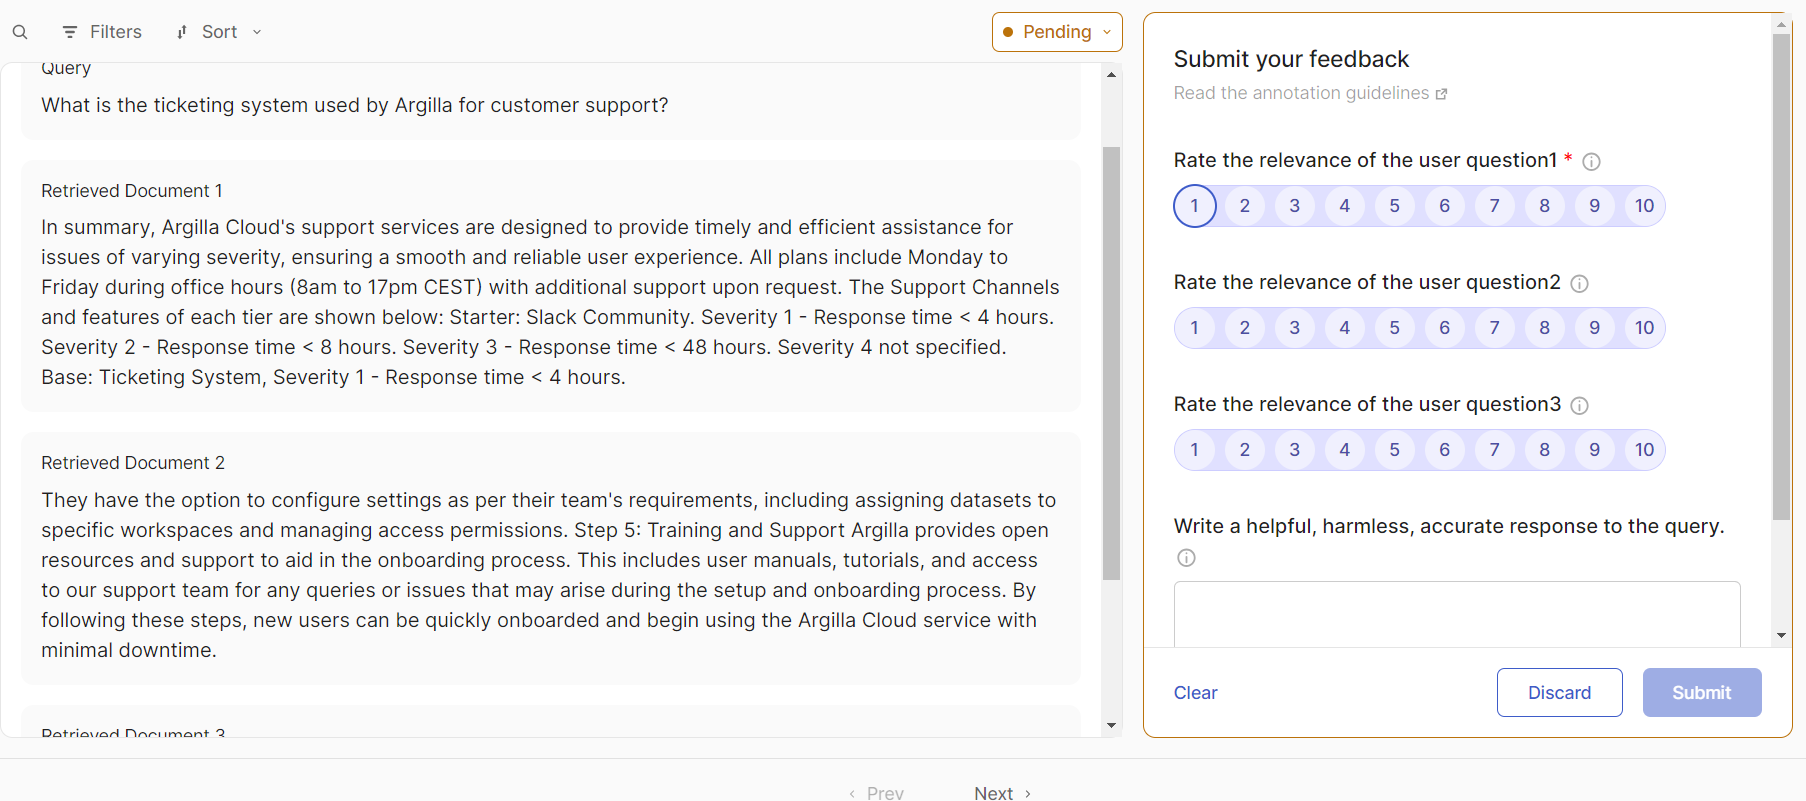

#### For Sentence Similarity

The flow is similar to the previous one. We initialize the template, add the metadata property (in this case, the source would be useful to know the origin of the contexts we're comparing) and, as we want to compare the three sentences, but the cross-encoder only supports a comparison of two sentences, we iterate over the three contexts to match them as 1-2, 1-3 and 2-3. Then, we add the records, and push it to Argilla.

In [ ]:
# Initialize the FeedbackDatasetTemplate
dataset_ssim = rg.FeedbackDataset.for_sentence_similarity(
    rating_scale=10,
    use_markdown=True,
    guidelines=None,
    metadata_properties=None,
    vectors_settings=None,
)
dataset_ssim

FeedbackDataset(
   fields=[TextField(name='sentence-1', title='Sentence-1', required=True, type='text', use_markdown=True), TextField(name='sentence-2', title='Sentence-2', required=True, type='text', use_markdown=True)]
   questions=[RatingQuestion(name='similarity', title='Similarity', description='Rate the similarity between the two sentences.', required=True, type='rating', values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])]
   guidelines=This is a sentence similarity dataset that contains two sentences. Please rate the similarity between the two sentences.)
   metadata_properties=[])
)

In [ ]:
# Add the new metadata property
metadata = rg.TermsMetadataProperty(name="sources", title="Model sources", values=["flan-t5-large/flan-t5-large"])

dataset_ssim.add_metadata_property(metadata)

TermsMetadataProperty(name='sources', title='Model sources', visible_for_annotators=True, type='terms', values=['flan-t5-large/flan-t5-large'])

In [ ]:
# Create the proper records
records = []
for context in tqdm(contexts):
    for i in range(len(context)):
        for j in range(i + 1, len(context)):
            record = rg.FeedbackRecord(
                fields={"sentence1": context[i], "sentence2": context[j]},
                metadata={"sources": "flan-t5-large/flan-t5-large"}
            )
            records.append(record)

# Add records to the dataset
dataset_ssim.add_records(records)

In [ ]:
# Publish the dataset in the Argilla UI
dataset_ssim = dataset_ssim.push_to_argilla(name="my_ssim_dataset", workspace="admin")

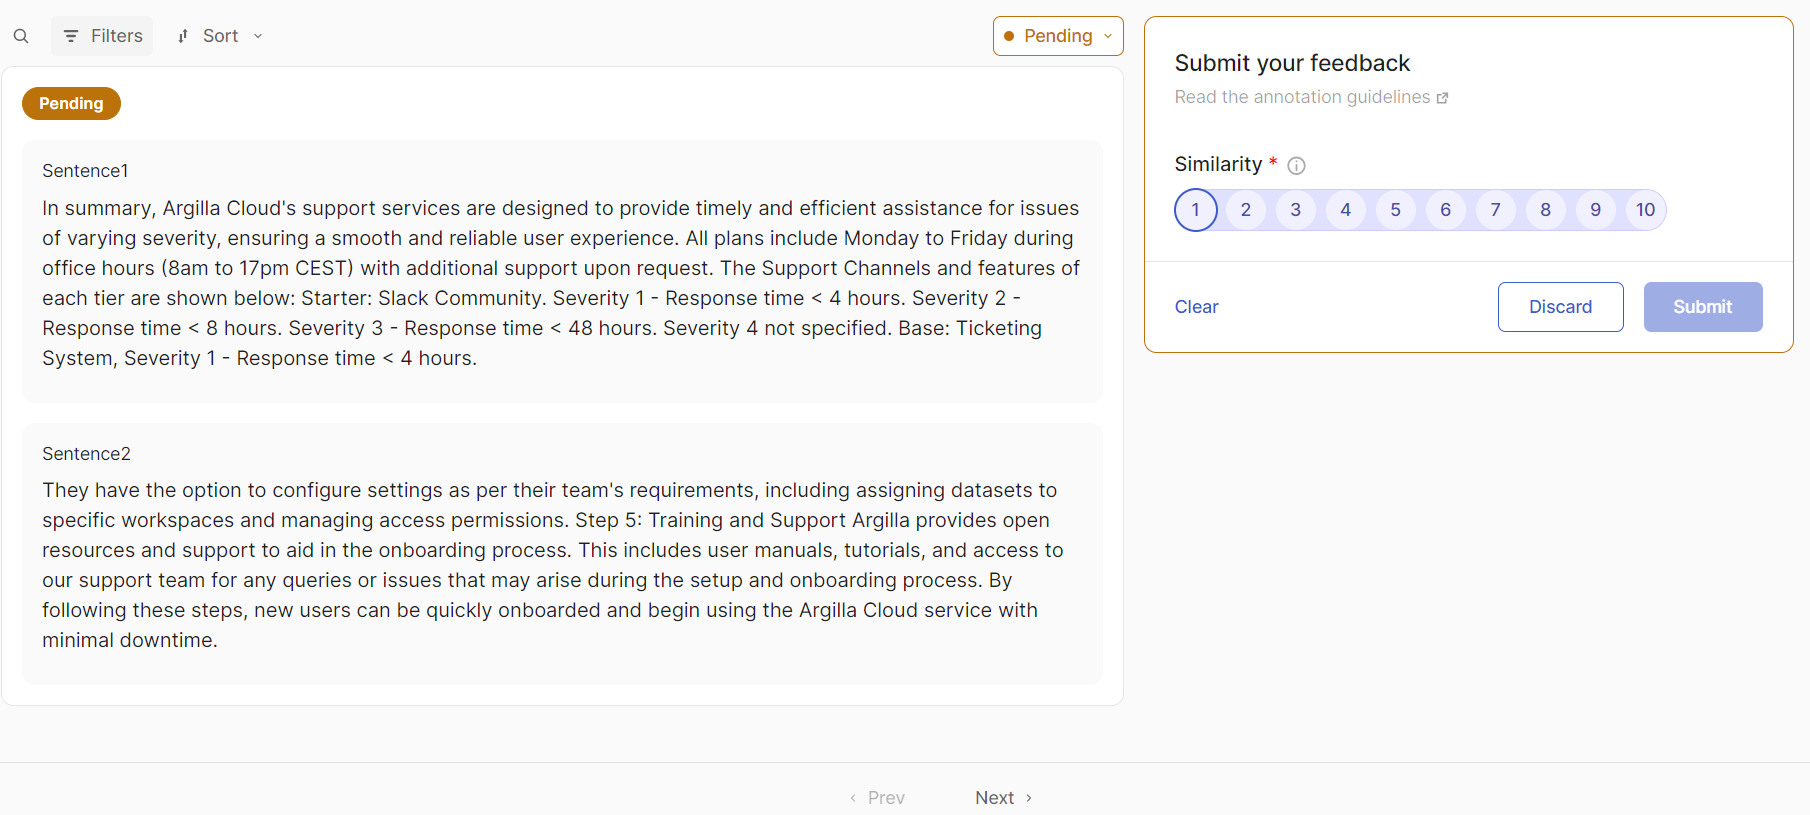

## Fine-tuning the Models

To improve the retrieval model, we need to [fine-tune a sentence similarity model](../../practical_guides/fine_tune.html#sentence-similarity), which compares the query embeddings and the context embeddings of the documents retrieved in the case of the bi-encoder and rank the contexts in the case of the cross-encoder. In this tutorial, we will fine-tune both models using the [ArgillaTrainer](../../practical_guides/fine_tune.html#argillatrainer) with the datasets we have created.

### Bi-Encoder Model

First, we prepare the data for fine-tuning the bi-encoder. Instead of using the default `TrainingTask.for_sentence_similarity`, we use the `formatting_func` so that we compare two sentences (the query and each of the contexts) and we add the rating value indicated by the annotators using the Argilla UI to be more precise.

Using the `ArgillaTrainer` is really easy to fine-tune a sentence similarity model. We just need to initialize the trainer and call `train`. To set if using the `bi-encoder` or the `cross-encoder`, we just need to set `framework_kwargs={"cross_encoder": False}` or `framework_kwargs={"cross_encoder": True}`. Check the [documentation](/practical_guides/fine_tune.html#training-configs) for further customization.

In [35]:
# Load the dataset from Argilla
dataset_rag = rg.FeedbackDataset.from_argilla("my_rag_dataset", workspace="admin")

In [38]:
# Define the training task using the formatting function
def formatting_func(sample):

    records = []

    for i in range(1, 4):
        record = {"sentence-1": sample["query"], "sentence-2": sample[f"retrieved_document_{i}"]}
        values = [resp["value"] for resp in sample[f"rating_retrieved_document_{i}"]]
        label = int(values[0])
        record["label"] = label
        records.append(record)

    return records

task = TrainingTask.for_sentence_similarity(formatting_func=formatting_func)

In [ ]:
# Fine-tune the bi-encoder
trainer_bi = ArgillaTrainer(
    dataset=dataset_rag,
    task=task,
    framework="sentence-transformers",
    framework_kwargs={"cross_encoder": False}
)
trainer_bi.train(output_dir="my_bi_sentence_transformer_model")

### Cross-Encoder Model

Our initial task is to prepare the data for fine-tuning the cross-encoder. Within the `TrainingTask.for_sentence_similarity function`, we explicitly focus on comparing only two contexts that the model will subsequently rank and add the rating annotation. This approach ensures that when the retrieval model retrieves documents, the cross-encoder can effectively rank them and return the most similar one.

Then, we initialize and run the trainer as we did with the bi-encoder. The only difference is that we set ``framework_kwargs={"cross_encoder": True}``. Check the [documentation](/practical_guides/fine_tune.html#training-configs) for further customization.

> 💭 Remember that the ``cross-encoder`` can not be trained with triplets.

In [ ]:
# Load the dataset from Argilla
dataset_ssim = rg.FeedbackDataset.from_argilla("my_ssim_dataset", workspace="admin")

In [ ]:
# Define the training task
task = TrainingTask.for_sentence_similarity(
    texts=[dataset_ssim.field_by_name("sentence-1"), dataset_ssim.field_by_name("sentence-2")],
    label=dataset_ssim.question_by_name("similarity")
)

In [ ]:
# Fine-tune the cross-encoder
trainer_cross = ArgillaTrainer(
    dataset=dataset_ssim,
    task=task,
    framework="sentence-transformers",
    framework_kwargs={"cross_encoder": True}
)
trainer_cross.train(output_dir="my_cross_sentence_transformer_model")

# Using our Models

We are now in the final step, so we are going to use our fine-tuned models again with Haystack so that we can get new and better predictions.

To do so, we will use the same questions and documents for RAG as previously. If you have completed all the preceding steps, then you can continue.

> Remember, it's unnecessary to reinitialize the document_store if the same documents are being used. However, ensure that the embeddings_dim align with those from our fine-tuned models. If there's a mismatch, reinitialize the document_store  with the correct values and run the TextIndexingPipeline.

First, we will initialize the `EmbeddingRetriever` with our fine-tuned bi-encoder model and update the embeddings. Then, we should add the [ranker](https://docs.haystack.deepset.ai/docs/ranker#sentencetransformersranker) by initializing the `SentenceTransformersRanker` with out fine-tuned cross-encoder model that will be used to boost our RAG model following the same idea as the diagram at the top.

In [ ]:
# Initialize the EmbeddingRetriever with out model
retriever = EmbeddingRetriever(
    document_store=document_store, embedding_model="my_bi_sentence_transformer_model"
)
document_store.update_embeddings(retriever)

In [ ]:
# Initialize the SentenceTransformersRanker with out model
ranker = SentenceTransformersRanker(model_name_or_path="my_cross_sentence_transformer_model")

As before, we should also initialize the prompt node with the `flan-t5-large` model and the `rag_prompt` template.

In [ ]:
# Write the prompt for RAG
rag_prompt = PromptTemplate(
    prompt="""Synthesize a comprehensive answer from the following text for the given question.
            Provide a clear and concise response.
            Your answer should be in your own words and be no longer than 50 words.
            \n\n Related text: {join(documents, delimiter=new_line, pattern=new_line+'Document[$idx]: $content', str_replace={new_line: ' ', '[': '(', ']': ')'})} \n Question: {query}; Answer: """,
            output_parser=AnswerParser(reference_pattern=r"Document\[(\d+)\]"),
)

# Initialize PromptNode
prompt_node = PromptNode(model_name_or_path="google/flan-t5-large", default_prompt_template=rag_prompt)

Now, let's create the final pipeline concatenating all the components! And run it!

In [ ]:
# Create the QA pipeline
pipe = Pipeline()
pipe.add_node(component=retriever, name="retriever", inputs=["Query"])
pipe.add_node(component=ranker, name="ranker", inputs=["retriever"])
pipe.add_node(component=prompt_node, name="prompt_node", inputs=["ranker"])

# Run the pipeline
questions = dataset["train"]["question"]
answers = []
contexts = []
  
for question in tqdm(questions):
    
    # Get the response and save it
    response = pipe.run(query=question)
    answers.append(response["answers"][0].answer)
    
    # Get the document context and save it
    prompt = response["answers"][0].meta['prompt']
    segments = re.split(r'Document\[\d+\]:', prompt)
    document_segments = [segment.strip() for segment in segments[1:]]    
    contexts.append(document_segments)

In [ ]:
# Question: the query asked the model
print(f"Question: {questions[0]}")

# Answer: the answer generated by the model
print(f"Answer: {answers[0]}")

# Contexts: a list of contexts retrieved by the model
print(f"Contexts: {contexts[0]}")

Question: What is the ticketing system used by Argilla for customer support?
Answer: Argilla Cloud's support services are designed to provide timely and efficient assistance for issues of varying severity, ensuring a smooth and reliable user experience. All plans include Monday to Friday during office hours (8am to 17pm CEST) with additional support upon request.
Contexts: ["In summary, Argilla Cloud's support services are designed to provide timely and efficient assistance for issues of varying severity, ensuring a smooth and reliable user experience. All plans include Monday to Friday during office hours (8am to 17pm CEST) with additional support upon request. The Support Channels and features of each tier are shown below: Starter: Slack Community. Severity 1 - Response time < 4 hours. Severity 2 - Response time < 8 hours. Severity 3 - Response time < 48 hours. Severity 4 not specified. Base: Ticketing System, Severity 1 - Response time < 4 hours.", 'This documents an overview of the

And as we can see, the results are much better than before and the ranker provided us the best context! 👏 

Now, all that's left is for you to experiment with various parameters – I'm confident you can enhance these results even further! 💪